# Project Report

1. Motivation / Goal
2. Preparation / Setup
3. Looking at bike data only
4. Looking at weather data only
5. Bike and weather data combined
6. Conclusion

## 1. Motivation / Goal

In this notebook we are trying to explore the relationship between bike traffic and various weather measurements. There is no concrete question to be answered or phenomenon to be explained but rather this project should provide an insight into the dynamics of pedestiran traffic.
The goal is to hopefully find interesting patterns and ultimately be able to build a model using which we can predict bike traffic soly on weather data so that in the future traffic could be estimated using weather forecasts.

To accomplish this task we are using Python to combine public data provided by the German city of Münster (Bike Traffic) combined with public data provided by DWD (German Weather Data). As such our target area is only in and around the city of Münster so it should be noted that results of this analysis might not be transferable to other regions of Germany or other parts of the World. That being said, we will take this compromise in this analysis because it will give us enough insight to generate a broad overview over the topic while simplifying our process greatly.

Let's start by setting up our dependencies and data before we first look at only bike data, then only weather data, and finally the both combined.

## 2. Preparation / Setup

In [343]:
# install requirements
%pip install -r ../requirements.txt

# import requirements
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from colorsys import hls_to_rgb, rgb_to_hls
import math

# hiding warnings for better visualisation
import warnings
warnings.filterwarnings('ignore')

# load data
bikes = pd.read_sql_table('bikes', 'sqlite:///../data/data.sqlite')
weather = pd.read_sql_table('weather', 'sqlite:///../data/data.sqlite')

ERROR: Invalid requirement: 'numpy=1.24.3' (from line 6 of ../requirements.txt)
Hint: = is not a valid operator. Did you mean == ?
Note: you may need to restart the kernel to use updated packages.


## 3. Looking at bike data only

Our data source provided traffic in hourly slots for multiple meassurement stations located all around the city. However we are not interested in distinguishing between different stations as we only have one weather station in the city. So for all futher exploration we assume that the weather is always the same in all parts of the city. This leaves us with the sum of all bike traffic meassured, for every given hour.

Note that this number does not neccessarily reflect the exact number of people who were riding their bike during the given timeframe as there could both be routes that don't involve any tracking stations, as well as routes that involve two or more stations. Though because we have a large number of trackers placed in all parts of the city, the number should stongly corrolate with the traffic generated by bikes. That's why we're going to call it **traffic** from now on.

So instead of thinking about the traffic number as people per hour, we have to think about it as "perceived traffic" (standing next to a bike lane and watching people pass by) or "time spent on bikes" (as in few people riding long distances result in the same number as many people riding short distances). This distinction is very important and should be kept in mind going forward.

---

To get started we want to look at bike data isolated, leaving weather out of the equation for now. This leaves us with only one other metric to categorize bike data with; And that is time.

We'll group the traffic into different buckets for visualization.

In [344]:
byDate20 = {}
byDate21 = {}
byHour = {}
byWeekday = {}
byMonth = {}

for idx, row in bikes.iterrows():
    count = row['count']
    date, hour = row['id'].split(' ')
    year, month, day = date.split('-')

    date_without_year = month + '-' + day
    if not date_without_year in byDate20:
        byDate20[date_without_year] = 0
    if not date_without_year in byDate21:
        byDate21[date_without_year] = 0
    if year == '2020':
        byDate20[date_without_year] += count
    else:
        byDate21[date_without_year] += count

    if not hour in byHour:
        byHour[hour] = 0
    byHour[hour] += count

    weekday = str(datetime.date(int(year), int(month), int(day)).weekday())
    if not weekday in byWeekday:
        byWeekday[weekday] = 0
    byWeekday[weekday] += count

    if not month in byMonth:
        byMonth[month] = 0
    byMonth[month] += count

Data is loaded, let's get started by simply plotting the total traffic (sum) of any given day of the year. Because our dataset exists of two years (2020 + 2021), we will see two lines, one for each year.

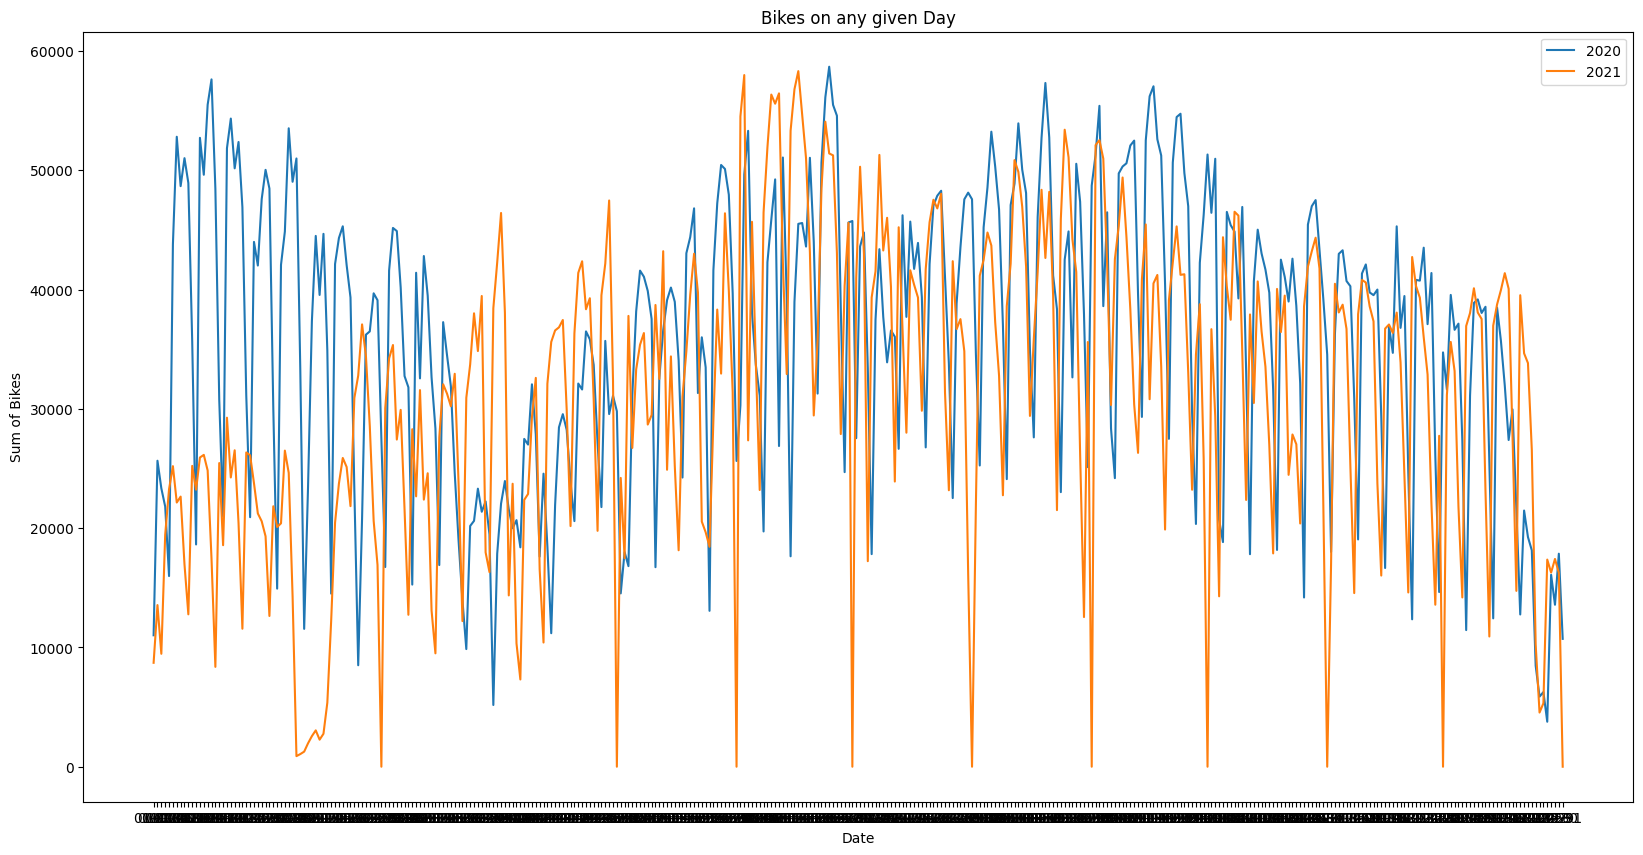

In [345]:
plt.figure(figsize=(20, 10))
plt.plot(byDate20.keys(), byDate20.values(), label="2020")
plt.plot(byDate21.keys(), byDate21.values(), label="2021")
plt.xlabel("Date")
plt.ylabel("Sum of Bikes")
plt.title("Bikes on any given Day")
plt.legend()
plt.show()

As expected this is not very telling. Let's try to find patterns anyway:
1. It looks like there is a positive trend in the warmer months (middle of the graph) while colder months (especially in 2021) seem to have less traffic overall)
2. It looks like the number is varying a lot per week.

First let's see if we can confirm guess number 1 by looking at total traffic per month:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


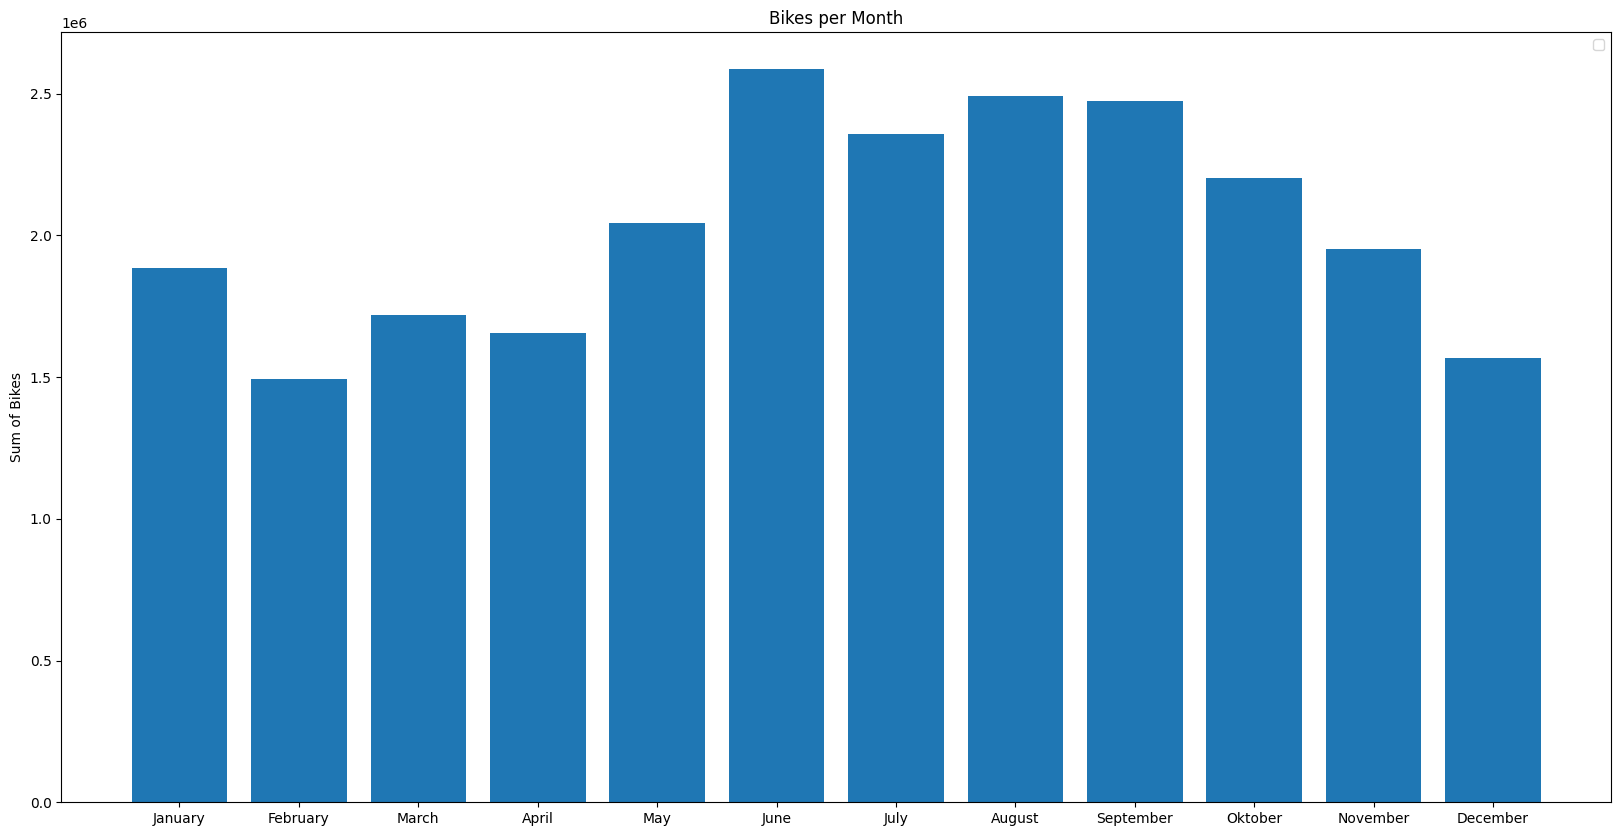

In [346]:
month_names = [ 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'Oktober', 'November', 'December' ]

plt.figure(figsize=(20, 10))
plt.bar([month_names[int(x)-1] for x in list(byMonth.keys())], byMonth.values())
plt.ylabel("Sum of Bikes")
plt.title("Bikes per Month")
plt.legend()
plt.show()

And yes we can confirm that during summer we have on average around 25% more traffic than during winter months.

To build on this let's already make another guess, we'll have to verify or deny later: Summer months are busier because of the warmer temperatures.

Next up let's look at our second guess from earlier: Traffic by weekday

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


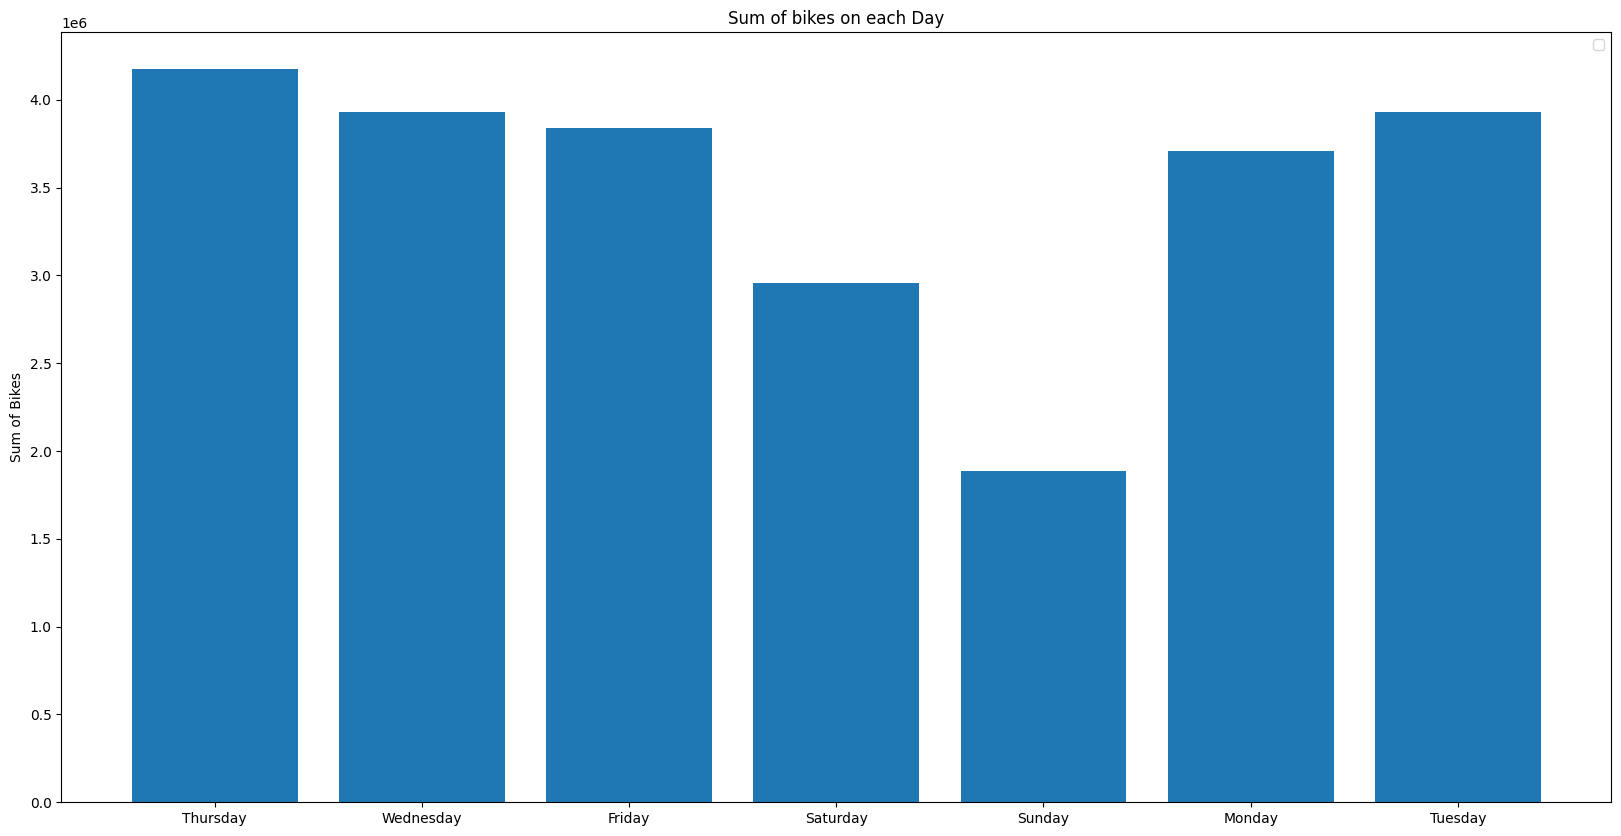

In [347]:
day_names = [ 'Monday', 'Tuesday', 'Thursday', 'Wednesday', 'Friday', 'Saturday', 'Sunday' ]

plt.figure(figsize=(20, 10))
plt.bar([day_names[int(x)] for x in list(byWeekday.keys())], byWeekday.values())
plt.ylabel("Sum of Bikes")
plt.title("Sum of bikes on each Day")
plt.legend()
plt.show()

Interestingly the weekend (especially Sunday) is less then half as busy the average workday. Apparently a lot of people use their bikes more as a means of transportation, to get to places like work or shopping, rather than a hobby activity or sport to do in their free time.

Finally let us take a look at which hours are the busiest:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


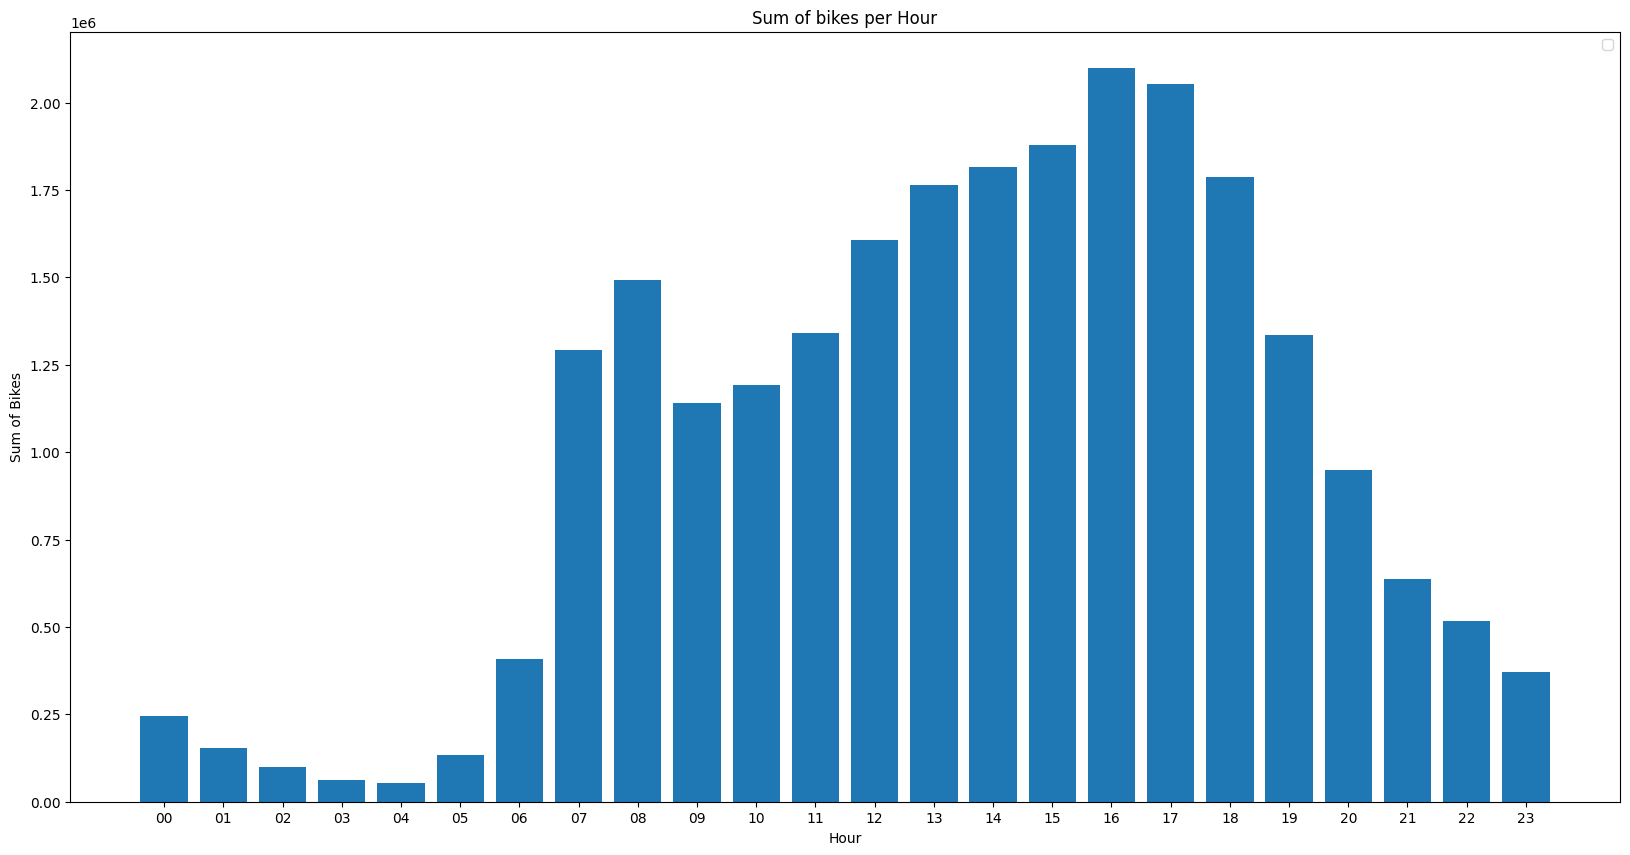

In [348]:
plt.figure(figsize=(20, 10))
plt.bar(byHour.keys(), byHour.values())
plt.xlabel("Hour")
plt.ylabel("Sum of Bikes")
plt.title("Sum of bikes per Hour")
plt.legend()
plt.show()

As would be expected, traffic at night is a lot lower than during daytime. Additionally it is apparent that between 7:00 and 8:00 in the morning and around 16:00 to 18:00 in the evening are peak times. This would corrolate with our theory from earlier that stated a lot of people use their bike to get from and to work as those times line up with usual office hours.

So much about bike data, for now. Let's briefly take a look at our weather data.

## 4. Looking at weather data only

For our weather data, we again have datapoints plotted by hour. Only this time we have a lot more data per hour than just one field as with the bikes.

In [349]:
# an example row
weather.loc[weather['date'] == 2022010101]

,date,clouds_vn,ewind_fx911,temp_tt_tu,temp_rf_tu,vis_v_vv,prec_r1,wind_f,wind_d
17542,2022010101,7,7.2,12.8,86.0,20000.0,0.0,4.6,240


column | value
---|---
date | the date and time of this datapoint in format YYYYMMDDhh
clouds_vn | amounts of clouds with 1 being the least and 8 being the most
ewind_fx911 | no information provided by dwd. dataset is called "extreme winds" thus higher numbers most likely indicate higher wind speeds
temp_tt_tu | air temperature in °C, measured 2m above ground
temp_rf_tu | relative humidity in %
vis_v_vv | view distance in m
prec_r1 | precipitation in mm
wind_f | average wind speed in m/s
wind_d | average wind direction in °, with 0° being north

Let's first prepare some data to look at afterwards.

In [350]:
weather['date_hour'] = weather['date'] % 100
weather['date_day'] = np.floor(weather['date'] / 100).astype(int) % 100
weather['date_month'] = np.floor(weather['date'] / 10000).astype(int) % 100
weather['date_year'] = np.floor(weather['date'] / 1000000).astype(int) % 10000
weather['date_noyear'] = weather['date'] % 10000000
weather['date_noyear_c'] = weather['date_month']*31*24 + weather['date_day']*24 + weather['date_hour']
weather['date_monthday'] = weather['date_month']*31 + weather['date_day']

filter_is_2020 = weather['date_year'] == 2020
filter_is_2021 = weather['date_year'] == 2021
filter_is_right_year = weather['date_year'].isin([ 2020, 2021 ])

Now we'll start with some seemingly random views at our data to get an overview over what we got to work with.

We will begin with the average temperature throughout the day:

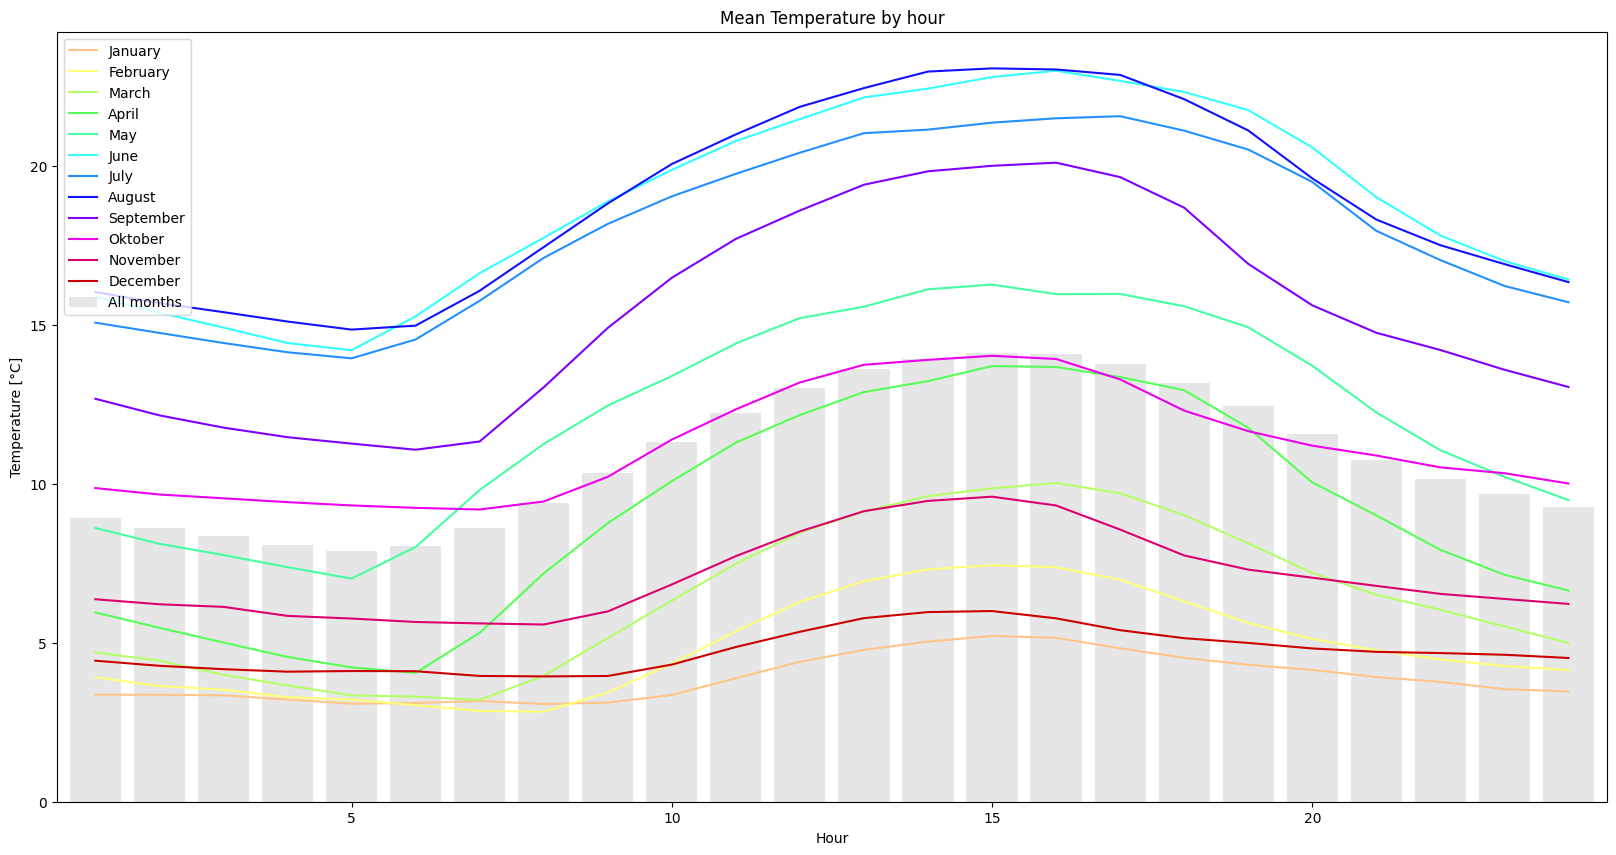

In [371]:
plt.figure(figsize=(20, 10))
data = weather[filter_is_right_year].groupby('date_hour').mean()
plt.bar(range(1,25), data['temp_tt_tu'], color='0.9', label='All months')
for month in range(1, 13):
  data = weather[filter_is_right_year][weather['date_month']==month].groupby('date_hour').mean()
  plt.plot(range(1, 25), data['temp_tt_tu'], label=month_names[month-1], color=hls_to_rgb(month/12, 0.8 - month/30, 1))
plt.xlim(0.4, 24.6)
plt.xlabel("Hour")
plt.ylabel("Temperature [°C]")
plt.title("Mean Temperature by hour")
plt.legend()
plt.show()

Next up all recorded temperatures in the two years we're having bike traffic data for: 2020 and 2021.

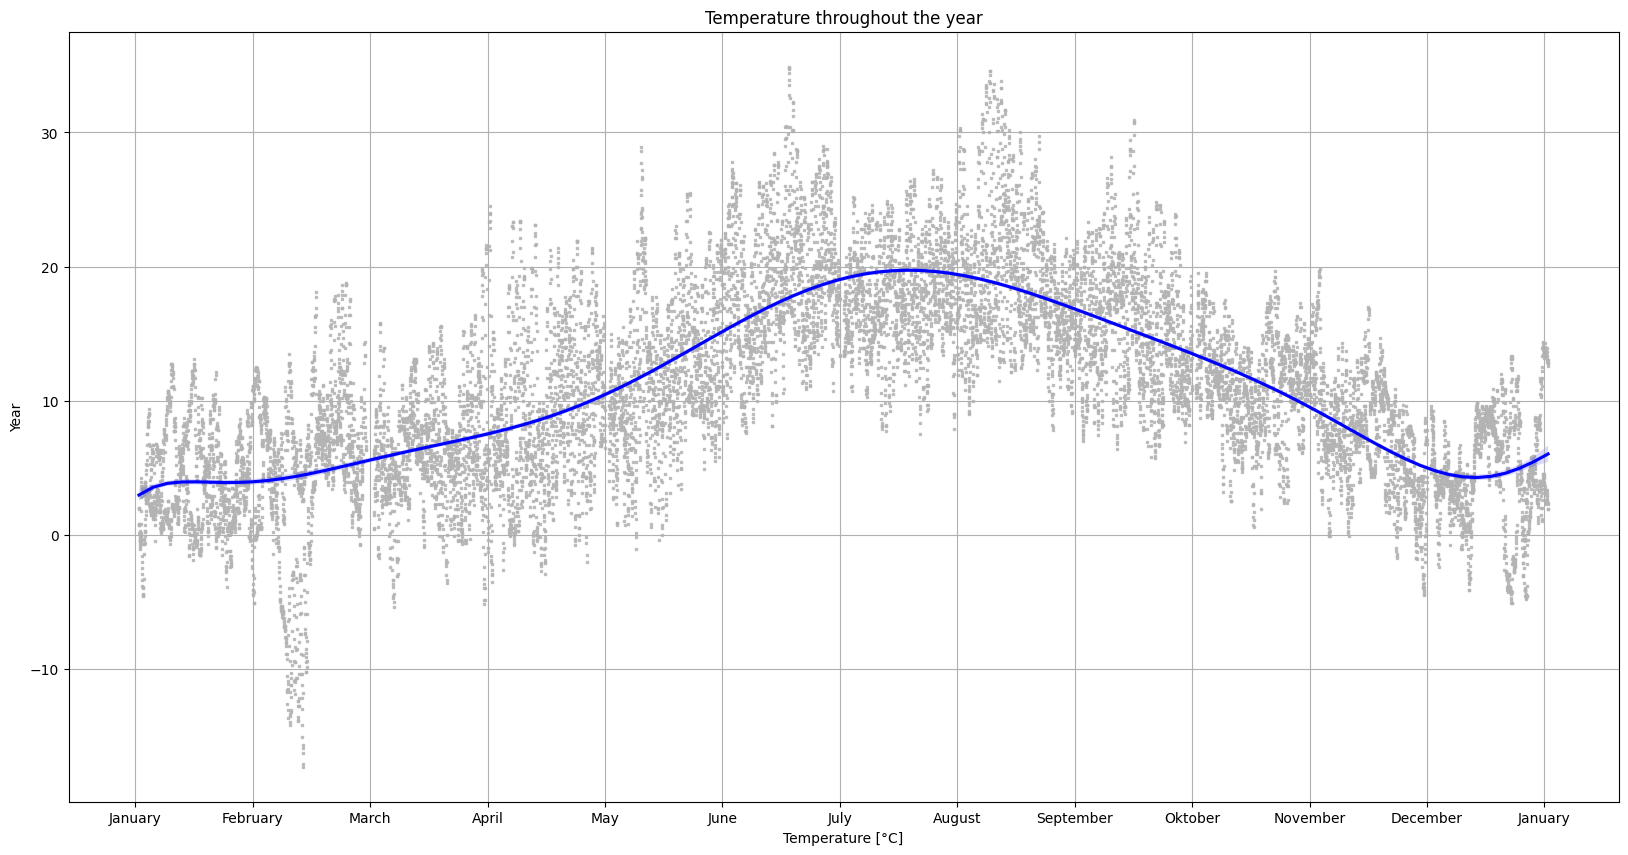

In [352]:
plt.figure(figsize=(20, 10))

data = weather[filter_is_right_year].groupby('date_noyear', as_index=False).mean()
plt.xticks([ x*31*24 for x in range(1, 14) ], [*month_names, month_names[0]])
sns.regplot(x=data['date_noyear_c'], y=data['temp_tt_tu'], marker=',', color='blue', order=10, ci=90, scatter_kws={'s':1, 'color':'.7'})

plt.xlabel("Year")
plt.ylabel("Temperature [°C]")
plt.title("Temperature throughout the year")
plt.grid(True)
plt.show()

Now onto precipitation throughout the year. The blue bars are total precipitation per day, the gray bars are the average daily amount within each month.

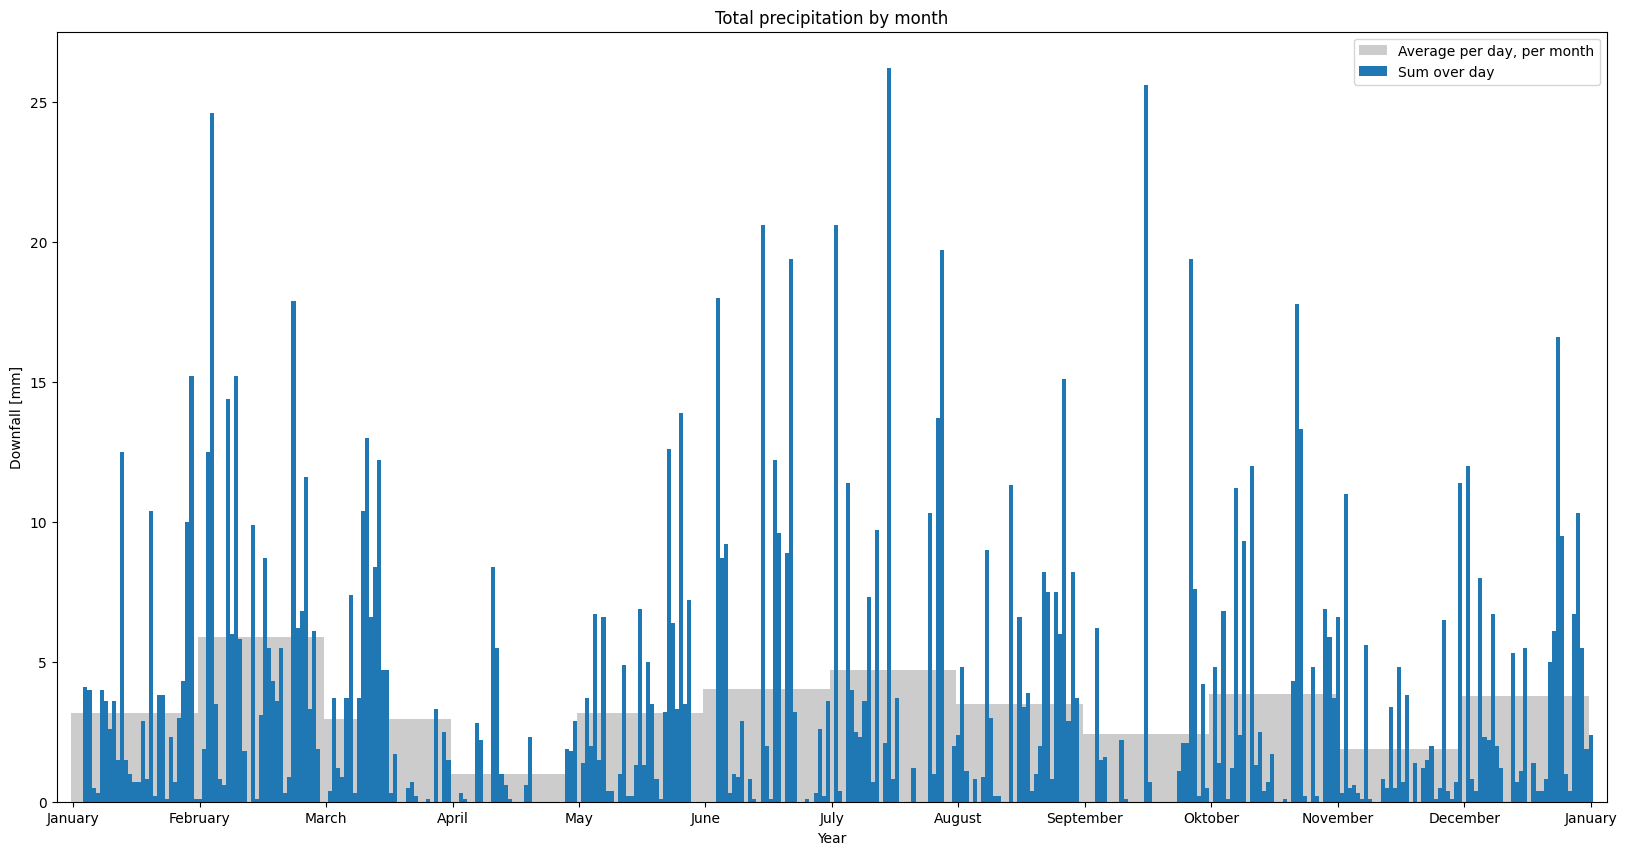

In [407]:
plt.figure(figsize=(20, 10))

data = weather[filter_is_right_year]
data = data[data['prec_r1'] >= 0]

plt.xticks([ x*31 for x in range(1, 14) ], [*month_names, month_names[0]])
plt.xlim(31-4, 31*13+4)

data_1 = data.groupby('date_month', as_index=False).sum()
plt.bar(data_1['date_month']*31 + 15, data_1['prec_r1'].abs()/31, color='0.8', width=31, label='Average per day, per month')

data_2 = data.groupby('date_monthday', as_index=False).sum()
plt.bar(data_2['date_monthday'], data_2['prec_r1'].abs(), width=1, label='Sum over day')

plt.xlabel("Year")
plt.ylabel("Downfall [mm]")
plt.title("Total precipitation by month")
plt.legend()
plt.show()

Let's also quickly look at view distance and humidity as they could also have a huge impact on how likely people are to use the bike.

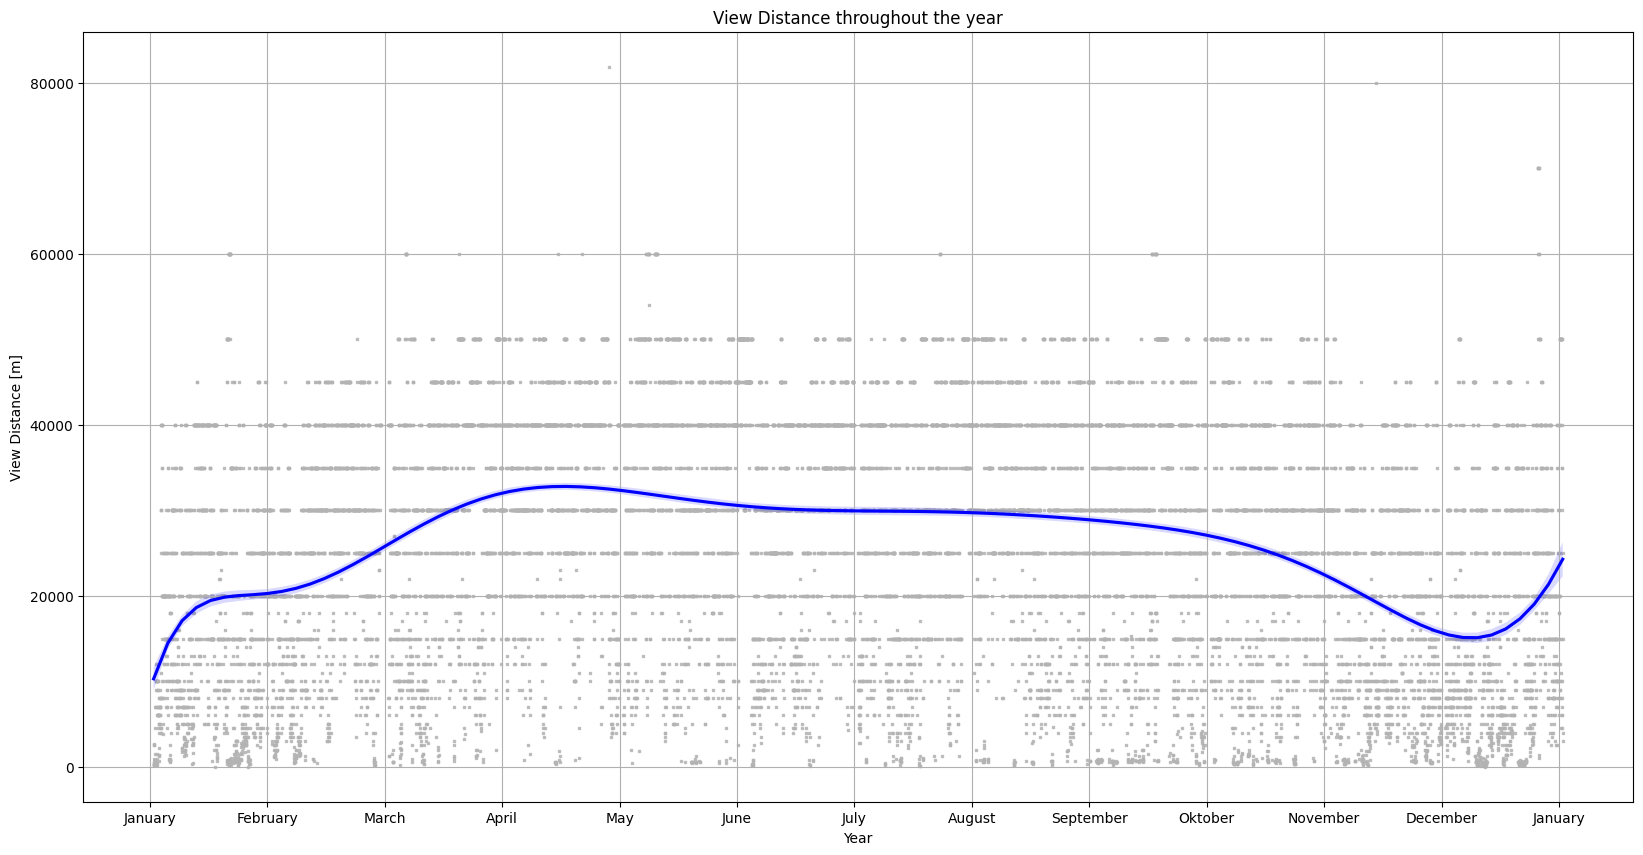

In [410]:
plt.figure(figsize=(20, 10))

data = weather[filter_is_right_year].groupby('date_noyear', as_index=False).mean()
plt.xticks([ x*31*24 for x in range(1, 14) ], [*month_names, month_names[0]])
sns.regplot(x=data['date_noyear_c'], y=data['vis_v_vv'], marker=',', color='blue', order=10, ci=90, scatter_kws={'s':1, 'color':'.7'})

plt.xlabel("Year")
plt.ylabel("View Distance [m]")
plt.title("View Distance throughout the year")
plt.grid(True)
plt.show()

As is to be expected, average view distance goes down a little during the colder seasons due to fog and snow.

Let's finish the weather exploration with a quick look at the average humidity on every day.

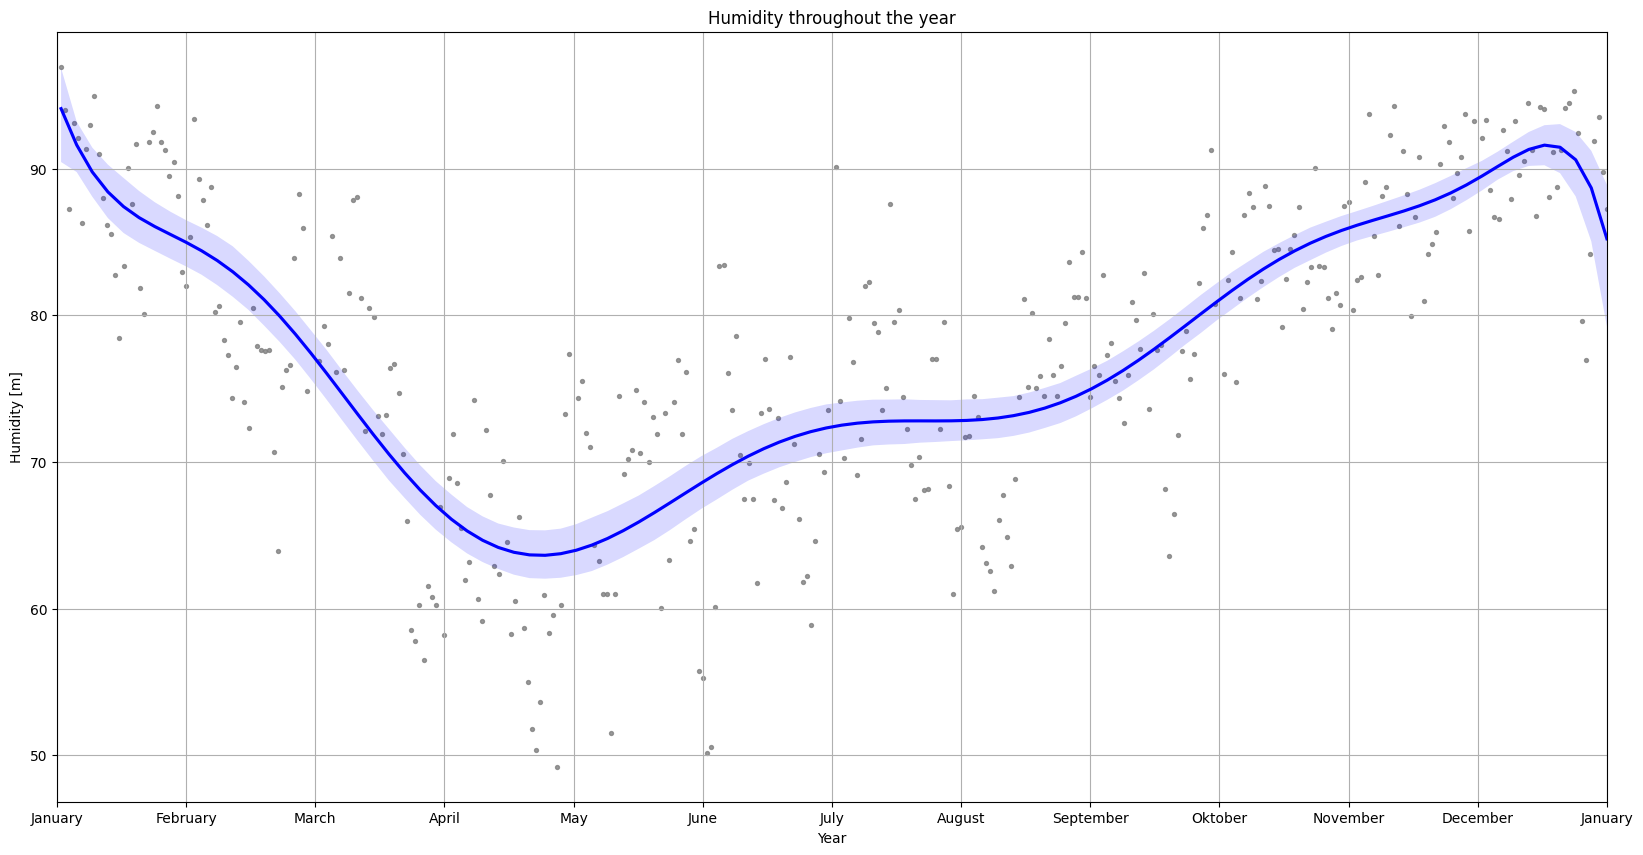

In [419]:
plt.figure(figsize=(20, 10))

data = weather[filter_is_right_year].groupby('date_monthday', as_index=False).mean()
plt.xticks([ x*31 for x in range(1, 14) ], [*month_names, month_names[0]])
plt.xlim(31, 31*13)
sns.regplot(x=data['date_monthday'], y=data['temp_rf_tu'], marker='.', color='blue', order=10, ci=90, scatter_kws={'s':32, 'color':'.5'})

plt.xlabel("Year")
plt.ylabel("Humidity [m]")
plt.title("Humidity throughout the year")
plt.grid(True)
plt.show()

## 5. Bike and weather data combined

## 6. Conclusion

ydadadawd

for future: it would be interesting to have data about other means of transportation (cars, public transport, walking) to see if people just get around less or if they switch to other transport options when bike traffic numbers are low